In [39]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Point
from scipy.spatial import KDTree
from collections import defaultdict
from typing import Dict, Tuple

In [95]:
gdf.columns

Index(['polygon_uuid', 'land_type', 'issue_year', 'edit_year', 'history',
       'last_polygon_uuid', 'prev_last_polygon_uuid', 'local_government_cd',
       'point_lng', 'point_lat', 'num_farm_pins', 'FarmCommitteeCd',
       'FarmCommitteeName', 'TodofukenCode', 'ShikuchosonCode', 'OazaCode',
       'ClassificationOfLandCodeName', 'ClassificationOfLand',
       'AreaOnRegistry', 'SectionOfNoushinhouCodeName', 'SectionOfNoushinhou',
       'SectionOfToshikeikakuhouCodeName', 'SectionOfToshikeikakuhou',
       'OwnerFarmIntentionCodeName', 'OwnerFarmIntention',
       'FarmerIndicationNumberHash', 'KindOfRightCodeName', 'KindOfRight',
       'RightSettingContentsCodeName', 'RightSettingContents',
       'UsageSituationInvestigationDate',
       'UsageSituationInvestigationResultCodeName',
       'UsageSituationInvestigationResult',
       'OwnerStatementIntentSurveyResultsCodeName',
       'OwnerStatementIntentSurveyResults',
       'UseIntentionAscertainmentResultCodeName',
       'Us

In [50]:
gdf = gpd.read_file('./data/part/clustered_farmland.geojson')
gdf.head()

,polygon_uuid,land_type,issue_year,edit_year,history,last_polygon_uuid,prev_last_polygon_uuid,local_government_cd,point_lng,point_lat,...,DaichoId,daicho_shubetsu_cd,CommencementDate,EndStagesDate,UseIntentionInvestigationDate,Settlement_id,Settlement_name,Settlement_pref,Settlement_city,geometry
0,845510f7-9879-4fc7-b242-b02d27ef77fd,100,2024,2021,"[ { ""筆ポリゴンID"": ""07bff886-1a8f-4e67-baa9-afbc3a...",07bff886-1a8f-4e67-baa9-afbc3a4ba4b4,83f40c4e-6a7a-491c-9d1f-79d033c9afca,082015,140.378607,36.373365,...,81009462,KNO01,20180401,20280331,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((392993.497 50172.34, 392986.87..."
1,bc1a920a-51ae-419e-ad96-70e99565ef7f,100,2024,2021,"[ { ""筆ポリゴンID"": ""b3ff9222-f24e-4f07-a8d6-bdabd3...",b3ff9222-f24e-4f07-a8d6-bdabd3a64894,ad4d9799-c4c2-4d10-946d-a8454b6e76d2,082015,140.375484,36.374615,...,81009523,KNO01,20160520,20260331,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((392663.088 50465.095, 392742.9..."
2,b9b25df0-4216-4c77-b45f-3d4f8f1e310b,100,2024,2020,"[ { ""筆ポリゴンID"": ""390f68b3-d956-4708-b5f9-db4a43...",390f68b3-d956-4708-b5f9-db4a43d81b14,da37b61d-992f-4715-8c07-47f7341d36da,082015,140.374759,36.370537,...,81009356,KNO01,20160701,20260630,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((392608.847 49984.025, 392612.8..."
3,f698aa22-480c-4a9e-8836-48e23d4e70e8,100,2024,2020,"[ { ""筆ポリゴンID"": ""8010d704-9f3a-49f6-9a39-53cfd1...",8010d704-9f3a-49f6-9a39-53cfd1f7ce99,a356ef22-721c-46f9-bca3-5182f757421a,082015,140.376201,36.375622,...,81009526,KNO01,None,None,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((392802.168 50619.271, 392815.2..."
4,bf7739ac-7e76-489b-ab47-e03b381ac73e,100,2024,2020,"[ { ""筆ポリゴンID"": ""78b37505-cc16-43ba-ac87-f7ab0c...",78b37505-cc16-43ba-ac87-f7ab0c3ae5b2,42e8e265-616a-4580-a13b-8e32482536e7,082015,140.377562,36.373640,...,81009469,KNO01,20160701,20260630,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((392864.079 50349.068, 392859.6..."


In [61]:
import numpy as np
ex_basepoints = {
    "2dacba93d45b0f46a25b29b985bd90e2": (140.375353413567, 36.374879510486224),
    "10aad9b486abee43973bb555cc3362c2": (140.3754835333555, 36.37461504064325),
    "7db8af145bda49552f855ba395906a2f": (140.37668934851857, 36.37346638402421)
}
area_nums = {
    "2dacba93d45b0f46a25b29b985bd90e2": 2,
    "10aad9b486abee43973bb555cc3362c2": 3,
    "7db8af145bda49552f855ba395906a2f": 2
}


In [ ]:


def _put_existing_farmers(
    gdf_multipoly: gpd.GeoDataFrame,
    ex_basepoint: Dict[str, Tuple[float, float]],
    area_nums: Dict[str, int]
) -> gpd.GeoDataFrame:

    # 各クラスターの重心を計算
    gdf_multipoly["centroid"] = gdf_multipoly.geometry.centroid
    centroids = list(gdf_multipoly["centroid"].apply(lambda p: (p.x, p.y)))

    # KDTreeを作成して最近傍探索を効率化
    tree = KDTree(centroids)

    # 各農家の最近傍クラスターを決定
    cluster_assignment = {}
    assigned_clusters = set()
    remaining_farmers = set(ex_basepoint.keys())

    # 各農家のbasepointをgpdプロット
    gdf_basepoint = gpd.GeoDataFrame(
        ex_basepoint,
        geometry=gpd.points_from_xy([lon for lon, lat in ex_basepoint.values()], [lat for lon, lat in ex_basepoint.values()])
    )

    for farmer_id, (lon, lat) in ex_basepoint.items():
        _, idx = tree.query((lon, lat))
        cluster_idx = gdf_multipoly.index[idx]

        if cluster_idx not in assigned_clusters:
            cluster_assignment[farmer_id] = [cluster_idx]
            assigned_clusters.add(cluster_idx)
            remaining_farmers.remove(farmer_id)

    # 重複してクラスターを持てなかった農家の再割り当て
    for farmer_id in remaining_farmers:
        _, idxs = tree.query((ex_basepoint[farmer_id]), k=len(centroids))
        for idx in idxs:
            cluster_idx = gdf_multipoly.index[idx]
            if cluster_idx not in assigned_clusters:
                cluster_assignment[farmer_id] = [cluster_idx]
                assigned_clusters.add(cluster_idx)
                break

    # 隣接クラスターの探索（バッファを利用）
    neighbors = defaultdict(set)
    buffer_size = 0.1  # 適切なバッファサイズを設定
    buffered_geometries = gdf_multipoly.geometry.buffer(buffer_size)

    for i, poly1 in gdf_multipoly.geometry.items():
        for j, poly2 in gdf_multipoly.geometry.items():
            if i != j and buffered_geometries[i].intersects(poly2):
                neighbors[i].add(j)
                neighbors[j].add(i)
    print(neighbors)

    # 各農家の所有数を増やす
    for farmer_id, required_area in area_nums.items():
        while len(cluster_assignment[farmer_id]) < required_area:
            print(f"farmer_id: {farmer_id}, required_area: {required_area}")
            current_clusters = cluster_assignment[farmer_id]
            candidate_clusters = set()

            for c in current_clusters:
                candidate_clusters.update(neighbors[c])

            candidate_clusters -= assigned_clusters
            if not candidate_clusters:
                print("candidate_clusters is empty")
                break

            new_cluster = min(candidate_clusters, key=lambda c: gdf_multipoly.loc[c, "centroid"].distance(Point(ex_basepoint[farmer_id])))
            cluster_assignment[farmer_id].append(new_cluster)
            assigned_clusters.add(new_cluster)

    # 結果をGeoDataFrameに反映
    assignment_series = pd.Series({c: f for f, clusters in cluster_assignment.items() for c in clusters})
    gdf_multipoly["farmer_id"] = gdf_multipoly.index.map(assignment_series.get)

    return gdf_multipoly


In [54]:
gdf = gdf.to_crs(epsg=4326)
gdf.geometry

0    MULTIPOLYGON (((140.37848 36.37185, 140.37842 ...
1    MULTIPOLYGON (((140.37496 36.37462, 140.37585 ...
2    MULTIPOLYGON (((140.37411 36.37032, 140.37416 ...
3    MULTIPOLYGON (((140.37658 36.37595, 140.3767 3...
4    MULTIPOLYGON (((140.37713 36.37349, 140.37709 ...
5    MULTIPOLYGON (((140.38011 36.36918, 140.3805 3...
6    MULTIPOLYGON (((140.37711 36.36763, 140.3763 3...
7    MULTIPOLYGON (((140.37104 36.36766, 140.37098 ...
8    MULTIPOLYGON (((140.3692 36.37045, 140.36974 3...
9    MULTIPOLYGON (((140.37099 36.37111, 140.3709 3...
Name: geometry, dtype: geometry

In [96]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Point
from scipy.spatial import KDTree
from collections import defaultdict
from typing import Dict, Tuple

def _put_existing_farmers(
    gdf_multipoly: gpd.GeoDataFrame,
    ex_basepoint: Dict[str, Tuple[float, float]],
    area_nums: Dict[str, int]
) -> gpd.GeoDataFrame:

    # EPSG:4326 (緯度経度) に変換
    if gdf_multipoly.crs and gdf_multipoly.crs.to_epsg() != 4326:
        gdf_multipoly = gdf_multipoly.to_crs(epsg=4326)

    # 各クラスターの重心を計算
    gdf_multipoly["centroid"] = gdf_multipoly.geometry.centroid
    centroids = gpd.GeoDataFrame(geometry=gdf_multipoly["centroid"], crs=gdf_multipoly.crs)

    # 農家のbasepointsをGeoDataFrameに変換
    farmer_points = gpd.GeoDataFrame(
        geometry=[Point(lon, lat) for lon, lat in ex_basepoint.values()],
        crs="EPSG:4326"
    )

    # 可視化
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_multipoly.plot(ax=ax, facecolor="none", edgecolor="black")
    centroids.plot(ax=ax, color='red', markersize=50, label='Cluster Centroids')
    farmer_points.plot(ax=ax, color='blue', markersize=50, label='Farmer Basepoints')
    ax.legend()
    plt.show()

    # KDTreeを作成して最近傍探索を効率化
    tree = KDTree(centroids.geometry.apply(lambda p: (p.x, p.y)).tolist())

    # 各農家の最近傍クラスターを決定（被りなしを優先）
    cluster_assignment = {}
    assigned_clusters = set()
    remaining_farmers = set(ex_basepoint.keys())
    conflicted_farmers = []

    for farmer_id, (lon, lat) in ex_basepoint.items():
        _, idx = tree.query((lon, lat))
        cluster_idx = gdf_multipoly.index[idx]

        if cluster_idx not in assigned_clusters:
            cluster_assignment[farmer_id] = [cluster_idx]
            assigned_clusters.add(cluster_idx)
            remaining_farmers.remove(farmer_id)
        else:
            conflicted_farmers.append((farmer_id, cluster_idx))

    # クラスターを増やす処理（最近傍ベースで拡張）
    def expand_farmer_clusters(farmer_id, required_area):
        while len(cluster_assignment[farmer_id]) < required_area:
            current_clusters = cluster_assignment[farmer_id]
            candidate_clusters = list(set(gdf_multipoly.index) - assigned_clusters)

            if not candidate_clusters:
                break

            if not current_clusters:
                # 最初のクラスターをbasepointからの距離で決める（すでに割り当てられたクラスターは除外）
                base_lon, base_lat = ex_basepoint[farmer_id]
                distances, indices = tree.query((base_lon, base_lat), k=len(gdf_multipoly))
                first_cluster = next((gdf_multipoly.index[i] for i in indices if gdf_multipoly.index[i] not in assigned_clusters), None)
                if first_cluster is None:
                    break
                cluster_assignment[farmer_id] = [first_cluster]
                assigned_clusters.add(first_cluster)
                current_clusters = [first_cluster]

            new_cluster = min(
                (c for c in candidate_clusters if c not in assigned_clusters),
                key=lambda c: min(
                    (gdf_multipoly.loc[c, "centroid"].distance(gdf_multipoly.loc[cc, "centroid"])
                     for cc in current_clusters),
                    default=float("inf")
                ),
                default=None
            )

            if new_cluster is not None:
                cluster_assignment[farmer_id].append(new_cluster)
                assigned_clusters.add(new_cluster)

    # まず被ってない農家に対してクラスターを拡張
    for farmer_id in list(cluster_assignment.keys()):
        expand_farmer_clusters(farmer_id, area_nums[farmer_id])
        print(f"farmer_id: {farmer_id}, clusters: {cluster_assignment[farmer_id]}")

    # 被った農家のうちクラスターに近い方を優先
    conflicted_farmers.sort(key=lambda x: tree.query(ex_basepoint[x[0]])[0])

    for farmer_id, _ in conflicted_farmers:
        if farmer_id not in cluster_assignment:
            cluster_assignment[farmer_id] = []
        expand_farmer_clusters(farmer_id, area_nums[farmer_id])

    # 結果をGeoDataFrameに反映
    assignment_series = pd.Series({c: f for f, clusters in cluster_assignment.items() for c in clusters})
    gdf_multipoly["farmer_id"] = gdf_multipoly.index.map(assignment_series.get)
    # reorganizedというカラムを作り、FarmerIndicationNumberHashが更新されたもののみTrueにする
    gdf_multipoly["reorganized"] = gdf_multipoly.index.isin(assignment_series.index)

    return gdf_multipoly

/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_87896/451506135.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_multipoly["centroid"] = gdf_multipoly.geometry.centroid


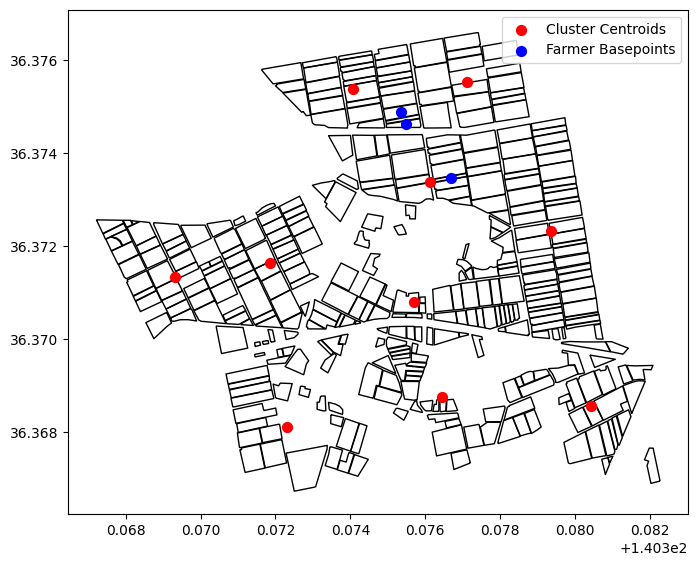

farmer_id: 2dacba93d45b0f46a25b29b985bd90e2, clusters: [1, 3]
farmer_id: 10aad9b486abee43973bb555cc3362c2, clusters: [4, 2, 6]


,polygon_uuid,land_type,issue_year,edit_year,history,last_polygon_uuid,prev_last_polygon_uuid,local_government_cd,point_lng,point_lat,...,EndStagesDate,UseIntentionInvestigationDate,Settlement_id,Settlement_name,Settlement_pref,Settlement_city,geometry,centroid,farmer_id,reorganized
0,845510f7-9879-4fc7-b242-b02d27ef77fd,100,2024,2021,"[ { ""筆ポリゴンID"": ""07bff886-1a8f-4e67-baa9-afbc3a...",07bff886-1a8f-4e67-baa9-afbc3a4ba4b4,83f40c4e-6a7a-491c-9d1f-79d033c9afca,082015,140.378607,36.373365,...,20280331,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((140.37848 36.37185, 140.37842 ...",POINT (140.37935 36.37233),7db8af145bda49552f855ba395906a2f,True
1,bc1a920a-51ae-419e-ad96-70e99565ef7f,100,2024,2021,"[ { ""筆ポリゴンID"": ""b3ff9222-f24e-4f07-a8d6-bdabd3...",b3ff9222-f24e-4f07-a8d6-bdabd3a64894,ad4d9799-c4c2-4d10-946d-a8454b6e76d2,082015,140.375484,36.374615,...,20260331,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((140.37496 36.37462, 140.37585 ...",POINT (140.37407 36.37536),2dacba93d45b0f46a25b29b985bd90e2,True
2,b9b25df0-4216-4c77-b45f-3d4f8f1e310b,100,2024,2020,"[ { ""筆ポリゴンID"": ""390f68b3-d956-4708-b5f9-db4a43...",390f68b3-d956-4708-b5f9-db4a43d81b14,da37b61d-992f-4715-8c07-47f7341d36da,082015,140.374759,36.370537,...,20260630,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((140.37411 36.37032, 140.37416 ...",POINT (140.37569 36.3708),10aad9b486abee43973bb555cc3362c2,True
3,f698aa22-480c-4a9e-8836-48e23d4e70e8,100,2024,2020,"[ { ""筆ポリゴンID"": ""8010d704-9f3a-49f6-9a39-53cfd1...",8010d704-9f3a-49f6-9a39-53cfd1f7ce99,a356ef22-721c-46f9-bca3-5182f757421a,082015,140.376201,36.375622,...,None,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((140.37658 36.37595, 140.3767 3...",POINT (140.37712 36.37551),2dacba93d45b0f46a25b29b985bd90e2,True
4,bf7739ac-7e76-489b-ab47-e03b381ac73e,100,2024,2020,"[ { ""筆ポリゴンID"": ""78b37505-cc16-43ba-ac87-f7ab0c...",78b37505-cc16-43ba-ac87-f7ab0c3ae5b2,42e8e265-616a-4580-a13b-8e32482536e7,082015,140.377562,36.373640,...,20260630,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((140.37713 36.37349, 140.37709 ...",POINT (140.37612 36.37338),10aad9b486abee43973bb555cc3362c2,True
5,0f31d0cd-fa6f-460d-9075-d480368ae029,100,2024,2020,"[ { ""筆ポリゴンID"": ""66206d29-c3a3-4eae-b4b9-8f8ba8...",66206d29-c3a3-4eae-b4b9-8f8ba8859013,26e3fc77-9102-4dcd-be5f-f13021275411,082015,140.380393,36.368976,...,20291231,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((140.38011 36.36918, 140.3805 3...",POINT (140.38042 36.36856),7db8af145bda49552f855ba395906a2f,True
6,e271c767-66e8-4826-9604-88e7e2b678ba,200,2024,2020,"[ { ""筆ポリゴンID"": ""b3ed608c-f6f6-4e20-8b71-2612a6...",b3ed608c-f6f6-4e20-8b71-2612a621157f,baaad857-b8f9-40e6-b2e3-164d286eab41,082015,140.376642,36.367816,...,None,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((140.37711 36.36763, 140.3763 3...",POINT (140.37645 36.36875),10aad9b486abee43973bb555cc3362c2,True
7,634cc64a-3c94-4bbd-87c6-2e651dc3fc05,200,2024,2020,"[ { ""筆ポリゴンID"": ""4d8479ab-3312-4a9d-9b28-f527fa...",4d8479ab-3312-4a9d-9b28-f527fa0d4a49,68c92169-40c4-427b-b009-828fb88cef4d,082015,140.371393,36.368400,...,20271231,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((140.37104 36.36766, 140.37098 ...",POINT (140.37232 36.36812),None,False
8,a3b7a025-6521-45f3-abd0-2e366f2f30e6,100,2024,2020,"[ { ""筆ポリゴンID"": ""72308bd2-9474-447c-8290-86fece...",72308bd2-9474-447c-8290-86fece2f7384,cab5ee9f-7ccc-4367-aa73-4779d0eaffa2,082015,140.369411,36.370652,...,20280331,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((140.3692 36.37045, 140.36974 3...",POINT (140.36933 36.37133),None,False
9,aafeadbb-6b8c-44ce-8b9f-78a97cdc31eb,100,2024,2020,"[ { ""筆ポリゴンID"": ""7eb74362-fc62-4195-8fb0-10fead...",7eb74362-fc62-4195-8fb0-10feada84acb,ceb9da87-aaa8-4124-82fc-cd6042e3440f,082015,140.370965,36.371707,...,20291231,None,006,筑地,茨城県,水戸市,"MULTIPOLYGON (((140.37099 36.37111, 140.3709 3...",POINT (140.37185 36.37163),None,False


In [97]:
ex_gdf = _put_existing_farmers(gdf, ex_basepoints, area_nums)
ex_gdf

In [ ]:
def plot_farmer_clusters(gdf_multipoly):
    fig, ax = plt.subplots(figsize=(8, 8))

    unique_farmers = gdf_multipoly["farmer_id"].dropna().unique()
    colors = plt.cm.get_cmap("tab10", len(unique_farmers))

    for i, farmer_id in enumerate(unique_farmers):
        sub_gdf = gdf_multipoly[gdf_multipoly["farmer_id"] == farmer_id]
        sub_gdf.plot(ax=ax, color=colors(i), label=f"Farmer {farmer_id}")
        print(farmer_id)

    plt.legend()
    plt.show()

7db8af145bda49552f855ba395906a2f
2dacba93d45b0f46a25b29b985bd90e2
10aad9b486abee43973bb555cc3362c2


/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_87896/4284842577.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_farmers))
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_87896/4284842577.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_87896/4284842577.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


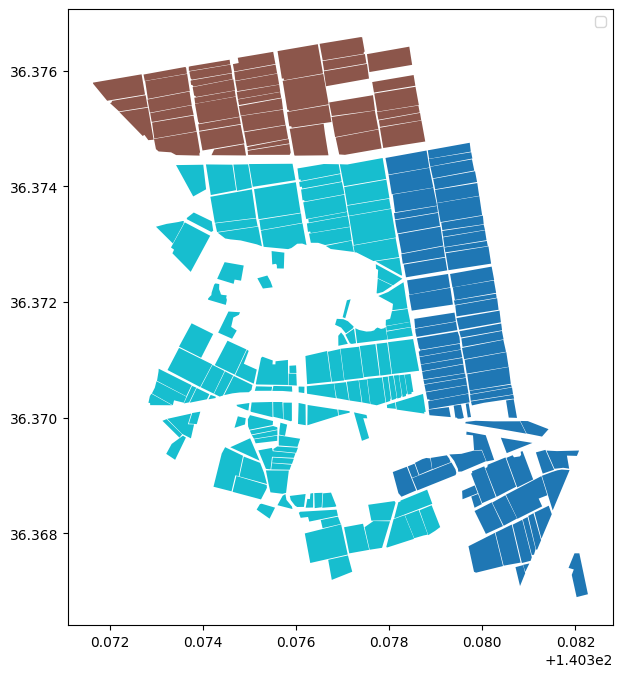

In [93]:
plot_farmer_clusters(ex_gdf)

In [26]:
ex_gdf.geometry

0    MULTIPOLYGON (((392993.497 50172.34, 392986.87...
1    MULTIPOLYGON (((392663.088 50465.095, 392742.9...
2    MULTIPOLYGON (((392608.847 49984.025, 392612.8...
3    MULTIPOLYGON (((392802.168 50619.271, 392815.2...
4    MULTIPOLYGON (((392864.079 50349.068, 392859.6...
5    MULTIPOLYGON (((393153.162 49882.772, 393187.2...
6    MULTIPOLYGON (((392891.268 49698.169, 392819.7...
7    MULTIPOLYGON (((392346.326 49676.707, 392339.5...
8    MULTIPOLYGON (((392167.026 49978.72, 392214.01...
9    MULTIPOLYGON (((392324.121 50059.076, 392315.0...
Name: geometry, dtype: geometry

In [94]:
import geopandas as gpd

# 複数のジオメトリ列がある場合、メインのジオメトリ列を指定
# ここでは 'geometry' 列をメインのジオメトリ列として使用
ex_gdf = ex_gdf.set_geometry('geometry')

# 他のジオメトリ列を削除
geometry_columns = ex_gdf.columns[ex_gdf.dtypes == 'geometry']
for col in geometry_columns:
    if col != 'geometry':
        ex_gdf = ex_gdf.drop(columns=[col])

# GeoJSONファイルとして保存
output_path = './data/part/1111clustered_farmland_with_farmers.geojson'
ex_gdf.to_file(output_path, driver='GeoJSON')
print(f"保存しました: {output_path}")

保存しました: ./data/part/1111clustered_farmland_with_farmers.geojson


In [27]:
# geojson

ex_gdf.to_file('./data/part/1111clustered_farmland_with_farmers.geojson', driver='GeoJSON')

ValueError: GeoDataFrame contains multiple geometry columns but GeoDataFrame.to_file supports only a single geometry column. Use a GeoDataFrame.to_parquet or GeoDataFrame.to_feather, drop additional geometry columns or convert them to a supported format like a well-known text (WKT) using `GeoSeries.to_wkt()`.